In [1]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO
import os
import numpy as np
from PIL import Image

In [2]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [3]:
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if i % 1000 == 0:
            print("[%d/%d] Tokenized the captions." %(i, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Creates a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Adds the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [18]:
vocab_path='./pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocab.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: %d" %len(vocab))
print("Saved the vocabulary wrapper to '%s'" %vocab_path)

Total vocabulary size: 9956
Saved the vocabulary wrapper to './pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocab.pkl'


In [17]:
vocab = build_vocab(json='./pytorch-tutorial/tutorials/03-advanced/image_captioning/data/annotations/captions_train2014.json',
                        threshold=4)

loading annotations into memory...
Done (t=1.38s)
creating index...
index created!
[0/414113] Tokenized the captions.
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the capt

In [4]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

In [5]:
def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if i % 100 == 0:
            print ("[%d/%d] Resized the images and saved into '%s'."
                   %(i, num_images, output_dir))

In [7]:
splits = ['train', 'val']
for split in splits:
    image_dir = 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/'+split+'2014'
    output_dir = 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/'+split+'_resized2014'
    image_size = [256, 256]
    resize_images(image_dir, output_dir, image_size)

[0/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[100/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[200/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[300/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[400/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[500/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[600/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'.
[700/82783] Resized the images and saved into 'pytorch-tutorial/tutorials/03-advanced/image_captioning/dat

In [6]:
class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths


def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for every iteration.
    # images: tensor of shape (batch_size, 3, 224, 224).
    # captions: tensor of shape (batch_size, padded_length).
    # lengths: list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        """Initialize the weights."""
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, images):
        """Extract the image feature vectors."""
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [66]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights."""
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features):
        """Samples captions for given image features (Greedy search)."""
        states=None
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(20):                                      # maximum sampling length
            hiddens, states = self.lstm(inputs, states)          # (batch_size, 1, hidden_size), 
            outputs = self.linear(hiddens.squeeze(1))            # (batch_size, vocab_size)
            predicted = outputs.max(1)[1]
            sampled_ids.append(predicted.unsqueeze(0))
            inputs = self.embed(predicted)
            inputs = inputs.unsqueeze(1)                         # (batch_size, 1, embed_size)
        sampled_ids = torch.cat(sampled_ids, 1) 
        return sampled_ids.squeeze(0)                                      # (batch_size, 20)

In [9]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

In [12]:
if not os.path.exists('pytorch-tutorial/tutorials/03-advanced/image_captioning/models/'):
    os.makedirs('pytorch-tutorial/tutorials/03-advanced/image_captioning/models/')

In [10]:
transform = transforms.Compose([ 
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [11]:
with open('pytorch-tutorial/tutorials/03-advanced/image_captioning/data/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

In [12]:
img_path='pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014'
caption_path='pytorch-tutorial/tutorials/03-advanced/image_captioning/data/annotations/captions_train2014.json'
batch_size=128
data_loader = get_loader(img_path,caption_path, vocab, 
                             transform, batch_size,
                             shuffle=True, num_workers=2)

loading annotations into memory...
Done (t=1.18s)
creating index...
index created!


In [13]:
embed_size=256
hidden_size=512
num_layers=1
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)

In [14]:
if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

In [15]:
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [12]:
log_step=10
save_step=1000
embed_size=256
hidden_size=512
num_layers=1
num_epochs=5
batch_size=128
num_workers=2
learning_rate=0.001
model_path='pytorch-tutorial/tutorials/03-advanced/image_captioning/models/'

In [17]:
total_step = len(data_loader)

In [18]:
for epoch in range(num_epochs):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = to_var(images, volatile=True)
            captions = to_var(captions)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            # Forward, Backward and Optimize
            decoder.zero_grad()
            encoder.zero_grad()
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            # Print log info
            if i % log_step == 0:
                print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f'
                      %(epoch, num_epochs, i, total_step, 
                        loss.data[0], np.exp(loss.data[0]))) 
                
            # Save the models
            if (i+1) % save_step == 0:
                torch.save(decoder.state_dict(), 
                           os.path.join(model_path, 
                                        'decoder-%d-%d.pkl' %(epoch+1, i+1)))
                torch.save(encoder.state_dict(), 
                           os.path.join(model_path, 
                                        'encoder-%d-%d.pkl' %(epoch+1, i+1)))

Epoch [0/5], Step [0/3236], Loss: 9.1974, Perplexity: 9871.5627
Epoch [0/5], Step [10/3236], Loss: 6.6615, Perplexity: 781.6876
Epoch [0/5], Step [20/3236], Loss: 5.4381, Perplexity: 230.0063
Epoch [0/5], Step [30/3236], Loss: 5.1369, Perplexity: 170.1890
Epoch [0/5], Step [40/3236], Loss: 4.7731, Perplexity: 118.2828
Epoch [0/5], Step [50/3236], Loss: 4.5814, Perplexity: 97.6540
Epoch [0/5], Step [60/3236], Loss: 4.5598, Perplexity: 95.5642
Epoch [0/5], Step [70/3236], Loss: 4.5302, Perplexity: 92.7799
Epoch [0/5], Step [80/3236], Loss: 4.3768, Perplexity: 79.5837
Epoch [0/5], Step [90/3236], Loss: 4.2877, Perplexity: 72.7971
Epoch [0/5], Step [100/3236], Loss: 4.1852, Perplexity: 65.7062
Epoch [0/5], Step [110/3236], Loss: 4.1310, Perplexity: 62.2426
Epoch [0/5], Step [120/3236], Loss: 4.1538, Perplexity: 63.6772
Epoch [0/5], Step [130/3236], Loss: 3.8402, Perplexity: 46.5370
Epoch [0/5], Step [140/3236], Loss: 3.9060, Perplexity: 49.7013
Epoch [0/5], Step [150/3236], Loss: 3.7705, P

OSError: Traceback (most recent call last):
  File "/home/zhihao/miniconda2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
  File "/home/zhihao/miniconda2/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
  File "<ipython-input-6-7e1e986e5b47>", line 27, in __getitem__
    image = Image.open(os.path.join(self.root, path)).convert('RGB')
  File "/home/zhihao/miniconda2/lib/python3.6/site-packages/PIL/Image.py", line 2519, in open
OSError: cannot identify image file 'pytorch-tutorial/tutorials/03-advanced/image_captioning/data/train_resized2014/COCO_train2014_000000510671.jpg'


In [13]:
def to_var(x, volatile=False):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, volatile=volatile)

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [14]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

In [67]:
encoder = EncoderCNN(embed_size)
encoder.eval()  # evaluation mode (BN uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder_path='pytorch-tutorial/tutorials/03-advanced/image_captioning/models/encoder-4-3000.pkl'
decoder_path='pytorch-tutorial/tutorials/03-advanced/image_captioning/models/decoder-4-3000.pkl'
encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))
if torch.cuda.is_available():
        encoder.cuda()
        decoder.cuda()

In [19]:
import matplotlib.pyplot as plt

In [20]:
%matplotlib inline

<start> a group of giraffes are standing in a field . <end>


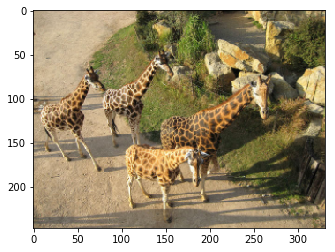

In [69]:
image = 'pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png'
image = load_image(image, transform)
image_tensor = to_var(image, volatile=True)
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids.cpu().data.numpy()
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)
print (sentence)
image = Image.open('pytorch-tutorial/tutorials/03-advanced/image_captioning/png/example.png')
plt.imshow(np.asarray(image))